In [1]:
import os, sys
sys.path.append('../../')
import numpy as np
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from adjustText import adjust_text
from utils.evaluate import get_jsdiv
from pandas.api.types import CategoricalDtype
basemap = cx.providers.CartoDB.VoyagerNoLabels

In [2]:
pth = os.path.join('..', '..', 'data', 'geodataframe_density.gpkg')
gdf = gpd.read_file(pth)
gdf_intl = gdf.loc[~gdf.US].copy(); gdf_intl

,city,state,country,latitude,longitude,population,msa,US,cluster,cluster_ref,log10_dpc,geometry
0,uruapan,michoacan,mexico,19.41116,-102.05644,264439,None,False,uruapan michoacan mexico,uruapan michoacan mexico,-6.105428,POINT (-11360870.933 2203403.664)
1,tepic,nayarit,mexico,21.50951,-104.89569,332863,None,False,tepic nayarit mexico,tepic nayarit mexico,-5.896653,POINT (-11676934.797 2452736.945)
2,fuzhou,fujian,china,26.06139,119.30611,3740000,None,False,fuzhou fujian china,fuzhou fujian china,-5.856990,POINT (13281095.414 3006686.347)
3,kunsan,jeonbuk,south korea,35.97860,126.71140,275155,None,False,kunsan jeonbuk south korea,kunsan jeonbuk south korea,-5.846182,POINT (14105448.526 4297677.164)
4,gunsan,jeollabuk do,south korea,35.97861,126.71139,243406,None,False,kunsan jeonbuk south korea,kunsan jeonbuk south korea,-5.792936,POINT (14105447.413 4297678.54)
...,...,...,...,...,...,...,...,...,...,...,...,...
24013,fort nelson,british columbia,canada,58.80533,-122.70020,3366,None,False,None,whistler british columbia canada,1.930744,POINT (-13658923.784 8138429.663)
24014,yellowknife,northwest territories,canada,62.45411,-114.37248,19569,None,False,None,morinville alberta canada,1.935475,POINT (-12731886.234 8967631.546)
24015,inuvik,northwest territories,canada,68.36166,-133.72817,3243,None,False,None,wasilla alaska united states,1.941344,POINT (-14886551.789 10555318.65)
24016,novokuznetsk,kemerovo oblast,russia,53.75570,87.10990,539616,None,False,None,chamba himachal pradesh india,1.961013,POINT (9697029.711 7124023.895)


## JS Divergence

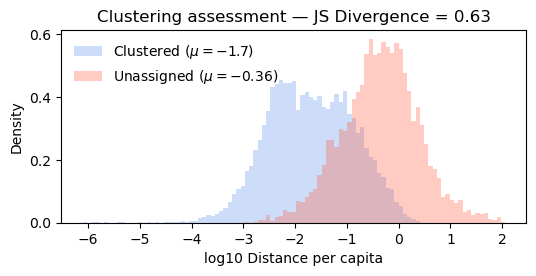

In [3]:
jsdiv, ax = get_jsdiv(gdf_intl, 'cluster',
                      plot = True,
                      return_ax = True,
                      clus_label = 'Clustered',
                      other_label = 'Unassigned')
ax.set_title(f'Clustering assessment — JS Divergence = {jsdiv.round(2)}')
ax.set_xlabel('log10 Distance per capita')
ax.set_ylabel('Density')
plt.show()

## Cluster Statistics

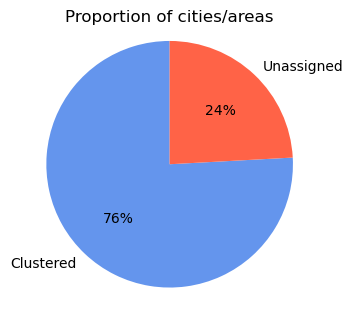

In [4]:
# proportion of cities in clusters
counts = gdf_intl.cluster.notna().value_counts().rename(
    {True : 'Clustered', False : 'Unassigned'})
fig, ax = plt.subplots(1, 1, figsize = (3.5, 3.5))
counts.plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    startangle = 90,
    colors = ['cornflowerblue', 'tomato'],
    ylabel = '',
    legend = False)
ax.set_title('Proportion of cities/areas')
ax.axis('equal')
plt.show()

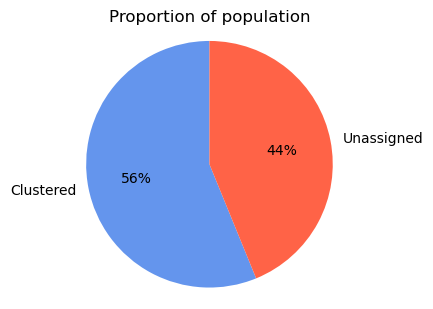

In [5]:
# proportion of population in clusters
population = gdf_intl.groupby(gdf_intl.cluster.notna()).population.sum()
population.index = population.index.map(
    {True : 'Clustered', False : 'Unassigned'})
population = population.loc[['Clustered', 'Unassigned']]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 3.5))
population.plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    startangle = 90,
    colors = ['cornflowerblue', 'tomato'],
    ylabel = '',
    legend = False)
ax.set_title('Proportion of population')
ax.axis('equal')
plt.show()

In [6]:
# high-level clustering statistics
clus_msk = gdf_intl.cluster.notna()
n_clus = gdf_intl.loc[clus_msk, 'cluster'].nunique()
pop_avg = (gdf_intl.loc[clus_msk]
           .groupby('cluster').population
           .sum().mean().astype(int))
n_city = (gdf_intl.loc[clus_msk]
          .groupby('cluster').city.
          count().mean().round(2))

print('Number of clusters =', n_clus)
print('Population average =', pop_avg)
print('Number of cities =', n_city)

Number of clusters = 1714
Population average = 779703
Number of cities = 7.47


## Population Percentiles

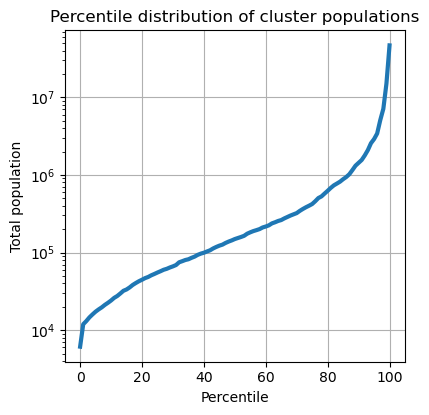

In [7]:
# cluster populations vs. percentiles
clus_pop = gdf_intl.loc[clus_msk].groupby('cluster').population.sum().sort_values()
percentile = np.arange(0, 101)
population = np.percentile(clus_pop, percentile)

fig, ax = plt.subplots(1, 1, figsize = (4.25, 4.25))
ax.plot(percentile, population, lw = 3)
ax.set_yscale('log')
ax.set_title('Percentile distribution of cluster populations')
ax.set_xlabel('Percentile')
ax.set_ylabel('Total population')
ax.grid(True)
plt.tight_layout()
plt.show()

## Worst & Best Cluster Assignments

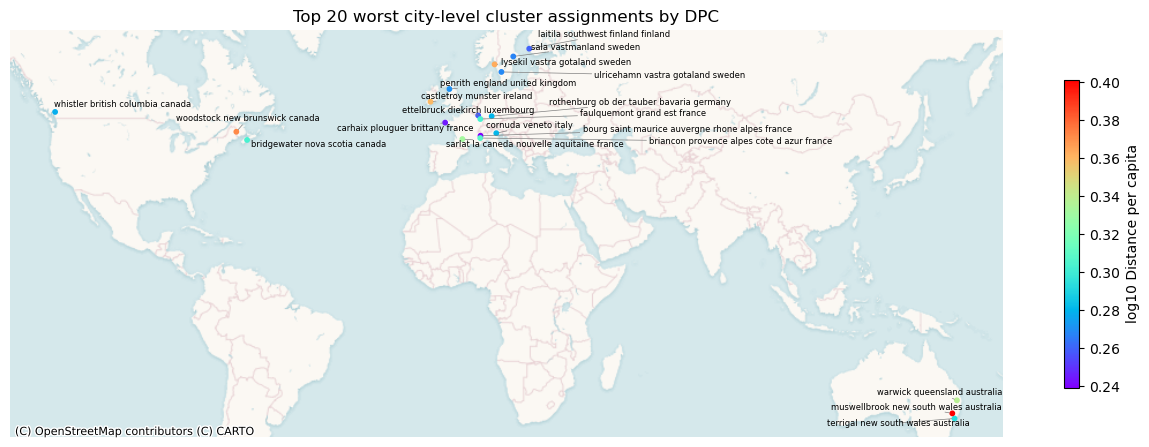

In [8]:
# worst city-level cluster assignments by DPC
top_n, ms, fs = 20, 10., 6.
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
gdf_plt = gdf_intl.loc[gdf_intl.cluster.notna()].copy()
gdf_plt.tail(top_n).plot(
    column = 'log10_dpc',
    cmap = 'rainbow',
    markersize = ms,
    legend = True,
    legend_kwds = {'label': 'log10 Distance per capita', 'shrink' : .25},
    ax = ax)
cx.add_basemap(ax, source = basemap)
labels = [ax.text(row.geometry.x, row.geometry.y, row.cluster, fontsize = fs)
          for _, row in gdf_plt.tail(top_n).iterrows()]
adjust_text(labels, ax = ax, arrowprops = dict(arrowstyle = '-', color = 'gray', lw = .5))
ax.set_title(f'Top {top_n} worst city-level cluster assignments by DPC')
ax.axis(False)
plt.show()

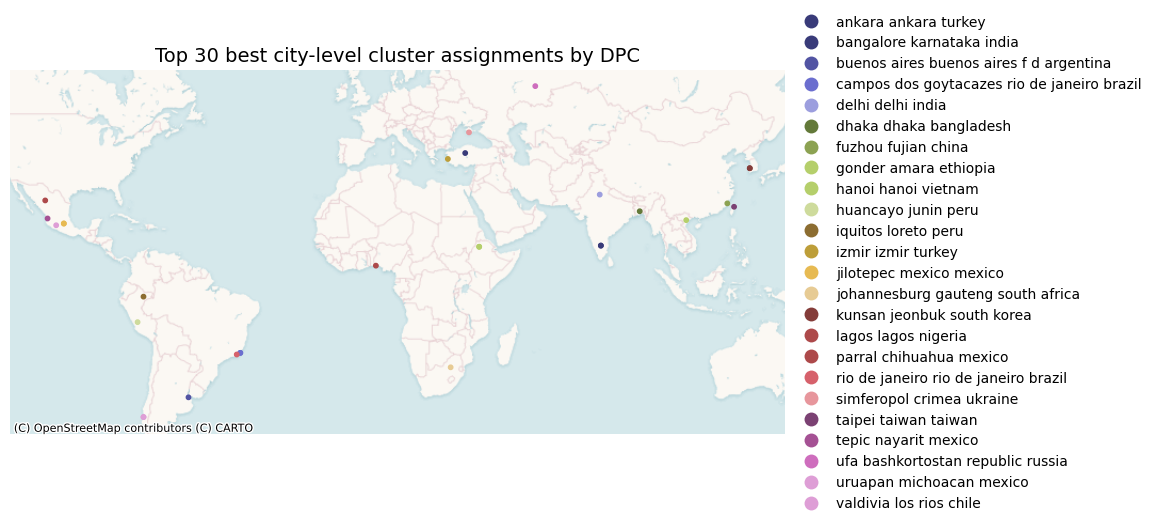

In [9]:
# best city-level cluster assignments by DPC
top_n = 30
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
gdf_plt.head(top_n).plot(
    column = 'cluster',
    cmap = 'tab20b',
    markersize = ms,
    legend = True,
    ax = ax)
cx.add_basemap(ax, source = basemap)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1.185))
leg.set_frame_on(False)
ax.set_title(f'Top {top_n} best city-level cluster assignments by DPC', size = 14)
ax.axis(False)
plt.show()

## Largest Clusters

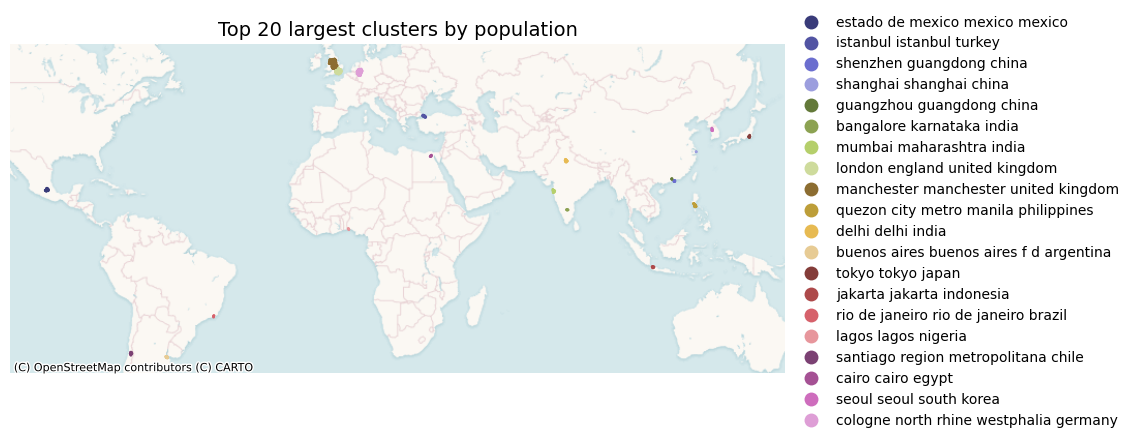

In [10]:
# largest clusters by poulation
top_n, ms = 20, 1.
largest = (gdf_intl.loc[gdf_intl.cluster.notna()]
           .groupby('cluster').population.sum()
           .sort_values(ascending = False)
           .head(top_n))
gdf_plt = gdf_intl.loc[gdf_intl.cluster.isin(largest.index)].copy()
gdf_plt['cluster_population'] = gdf_plt.cluster.map(largest)
gdf_plt.sort_values('cluster_population', ascending = False, inplace = True)
gdf_plt['cluster'] = gdf_plt.cluster.astype(
    CategoricalDtype(categories = gdf_plt.cluster.unique().tolist(), ordered = True))

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
gdf_plt.plot(
    column = 'cluster',
    cmap = 'tab20b',
    markersize = ms,
    legend = True,
    ax = ax)
cx.add_basemap(ax, source = basemap)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1.125))
leg.set_frame_on(False)
ax.set_title(f'Top {top_n} largest clusters by population', size = 14)
ax.axis(False)
plt.show()

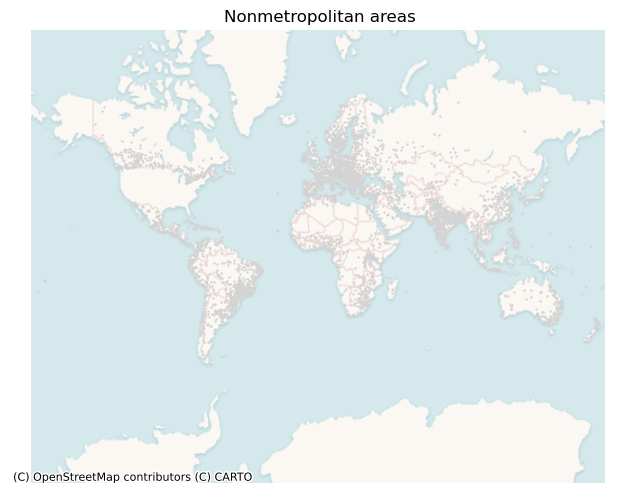

In [11]:
# unassigned nonmetropolitan areas
ms = .5
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
gdf_intl.loc[gdf_intl.cluster.isna()].plot(color = 'lightgrey',
                                           markersize = ms,
                                           ax = ax)
cx.add_basemap(ax, source = basemap, zorder = 0)
ax.set_title('Nonmetropolitan areas')
ax.axis(False)
plt.show()